# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
!mkdir -p data
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.67KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

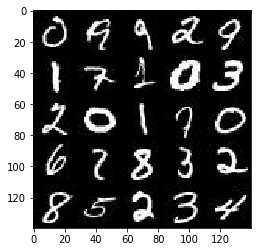

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

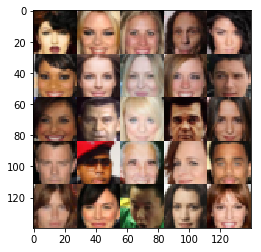

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [36]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_input")
    z_input = tf.placeholder(tf.float32, [None, z_dim], name="z_input")
    l_rate = tf.placeholder(tf.float32, name="l_rate")

    return real_input, z_input, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [49]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):        
        #Input is 28x28x3
        x = tf.layers.conv2d(images, filters=32, kernel_size=5, strides=2, padding="same")
        x = tf.maximum(alpha * x, x, "input")
        # 14x14x32
        
        cl1 = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=2, padding="same")
        cl1 = tf.layers.batch_normalization(cl1, training=True)
        cl1 = tf.maximum(alpha * cl1, cl1, "cl1")
        # 7x7x64
        
        #cl2 = tf.layers.conv2d(x, filters=128, kernel_size=4, strides=2, padding="same", use_bias=False)
        #cl2 = tf.layers.batch_normalization(cl2, training=True)
        #cl2 = tf.maximum(alpha * cl2, cl2, "cl2")
        # 4x4x128
        
        #cl3 = tf.layers.conv2d(x, filters=256, kernel_size=4, strides=2, padding="same", use_bias=False)
        #cl3 = tf.layers.batch_normalization(cl3, training=True)
        #cl3 = tf.maximum(alpha * cl3, cl3, "cl3")
        # 2x2x256
        
        # Flatten it
        flat = tf.reshape(cl1, (-1, 7*7*64))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [50]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope("generator", reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=not is_train)
        # Leaky ReLU
        x = tf.maximum(alpha * x, x, "input")
        # 3x3x512 now
        
        #cl1 = tf.layers.conv2d_transpose(x, 256, 3, 2, 'valid')
        #cl1 = tf.layers.batch_normalization(cl1, training=not is_train)
        #cl1 = tf.maximum(alpha * cl1, cl1, "cl1")
        # 7x7x256 now
        
        cl2 = tf.layers.conv2d_transpose(x, 128, 5, 2, 'same')
        cl2 = tf.layers.batch_normalization(cl2, training=not is_train)
        cl2 = tf.maximum(alpha * cl2, cl2, "cl2")
        # 14x14x128 now
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(cl2, out_channel_dim, 5, 2, 'same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [51]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function 
    # Taken as is from the DCGAN lesson
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [52]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    # Taken as is from the DCGAN lesson
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [53]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [54]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
                           print_every = 10, draw_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    losses = []
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    if data_image_mode == "RGB":
        channels = 3
    elif data_image_mode == "L":
        channels = 1
    else:
        assert False, "Image mode not recognised."
        
    steps = 0
   
    # Building the Model
    real_input, z_input, l_rate = model_inputs(data_shape[1], data_shape[2], channels, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model               
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, real_input: batch_images, l_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % draw_every == 0:
                    show_generator_output(sess, 25, z_input, channels, data_image_mode)
                    
        return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2681... Generator Loss: 0.4554
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.5920
Epoch 1/2... Discriminator Loss: 2.0802... Generator Loss: 1.6031
Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 0.6948
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 0.6855
Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 0.9101
Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 1.0025
Epoch 1/2... Discriminator Loss: 1.2192... Generator Loss: 2.4302
Epoch 1/2... Discriminator Loss: 0.8282... Generator Loss: 0.8831
Epoch 1/2... Discriminator Loss: 2.6805... Generator Loss: 0.0886


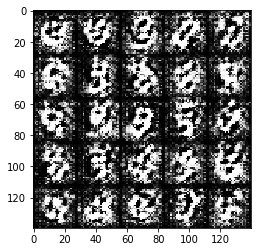

Epoch 1/2... Discriminator Loss: 1.7816... Generator Loss: 0.4188
Epoch 1/2... Discriminator Loss: 1.5185... Generator Loss: 0.8741
Epoch 1/2... Discriminator Loss: 1.7521... Generator Loss: 0.9741
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.6535
Epoch 1/2... Discriminator Loss: 1.3279... Generator Loss: 0.7682
Epoch 1/2... Discriminator Loss: 1.2613... Generator Loss: 0.8250
Epoch 1/2... Discriminator Loss: 1.3355... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 1.6906... Generator Loss: 1.5591
Epoch 1/2... Discriminator Loss: 1.2929... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 0.7195


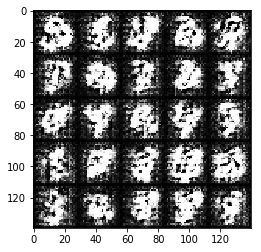

Epoch 1/2... Discriminator Loss: 1.7720... Generator Loss: 0.3089
Epoch 1/2... Discriminator Loss: 1.2313... Generator Loss: 0.7822
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 0.6511
Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 0.5329
Epoch 1/2... Discriminator Loss: 1.1445... Generator Loss: 1.4475
Epoch 1/2... Discriminator Loss: 0.9585... Generator Loss: 1.4393
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 1.2476
Epoch 1/2... Discriminator Loss: 0.8837... Generator Loss: 0.9610
Epoch 1/2... Discriminator Loss: 0.6771... Generator Loss: 1.1558
Epoch 1/2... Discriminator Loss: 0.7595... Generator Loss: 0.8240


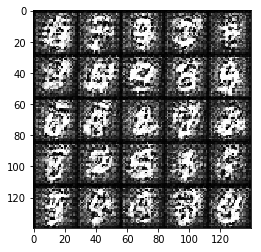

Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 0.3927
Epoch 1/2... Discriminator Loss: 0.7376... Generator Loss: 1.0706
Epoch 1/2... Discriminator Loss: 0.7882... Generator Loss: 0.8897
Epoch 1/2... Discriminator Loss: 0.6065... Generator Loss: 0.9945
Epoch 1/2... Discriminator Loss: 0.6966... Generator Loss: 0.9642
Epoch 1/2... Discriminator Loss: 0.5887... Generator Loss: 1.5671
Epoch 1/2... Discriminator Loss: 0.6745... Generator Loss: 1.0146
Epoch 1/2... Discriminator Loss: 0.7413... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 0.8893... Generator Loss: 0.7293


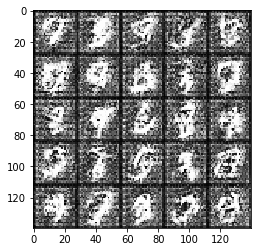

Epoch 1/2... Discriminator Loss: 0.5802... Generator Loss: 2.2454
Epoch 1/2... Discriminator Loss: 0.6063... Generator Loss: 1.4937
Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 1.1297
Epoch 1/2... Discriminator Loss: 0.7229... Generator Loss: 0.9748
Epoch 1/2... Discriminator Loss: 0.5521... Generator Loss: 1.9738
Epoch 1/2... Discriminator Loss: 0.9756... Generator Loss: 0.6121
Epoch 1/2... Discriminator Loss: 0.3582... Generator Loss: 1.9205
Epoch 1/2... Discriminator Loss: 0.2944... Generator Loss: 2.5215
Epoch 1/2... Discriminator Loss: 0.1927... Generator Loss: 2.9325
Epoch 1/2... Discriminator Loss: 0.3411... Generator Loss: 3.5815


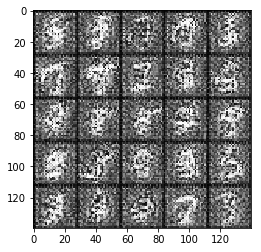

Epoch 1/2... Discriminator Loss: 1.2925... Generator Loss: 0.5557
Epoch 1/2... Discriminator Loss: 0.4057... Generator Loss: 1.6385
Epoch 1/2... Discriminator Loss: 0.1083... Generator Loss: 3.4718
Epoch 1/2... Discriminator Loss: 0.5463... Generator Loss: 1.1002
Epoch 1/2... Discriminator Loss: 0.1355... Generator Loss: 4.7269
Epoch 1/2... Discriminator Loss: 3.7419... Generator Loss: 2.5742
Epoch 1/2... Discriminator Loss: 0.7089... Generator Loss: 1.2633
Epoch 1/2... Discriminator Loss: 1.1552... Generator Loss: 0.4583
Epoch 1/2... Discriminator Loss: 0.7780... Generator Loss: 1.0310
Epoch 1/2... Discriminator Loss: 0.5464... Generator Loss: 1.4246


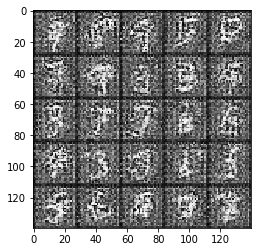

Epoch 1/2... Discriminator Loss: 0.6101... Generator Loss: 1.1434
Epoch 1/2... Discriminator Loss: 0.3132... Generator Loss: 2.2788
Epoch 1/2... Discriminator Loss: 0.4081... Generator Loss: 3.3197
Epoch 1/2... Discriminator Loss: 0.5976... Generator Loss: 1.0953
Epoch 1/2... Discriminator Loss: 0.3207... Generator Loss: 1.7075
Epoch 1/2... Discriminator Loss: 2.8690... Generator Loss: 0.1056
Epoch 1/2... Discriminator Loss: 2.2915... Generator Loss: 2.4950
Epoch 1/2... Discriminator Loss: 1.2407... Generator Loss: 0.6239
Epoch 1/2... Discriminator Loss: 1.1905... Generator Loss: 0.4937
Epoch 1/2... Discriminator Loss: 0.9145... Generator Loss: 1.3897


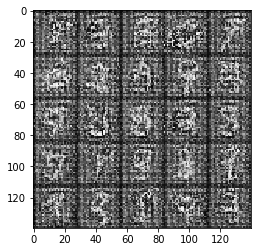

Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 0.9479
Epoch 1/2... Discriminator Loss: 0.8265... Generator Loss: 0.9359
Epoch 1/2... Discriminator Loss: 0.7853... Generator Loss: 0.8987
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 1.2660
Epoch 1/2... Discriminator Loss: 0.4125... Generator Loss: 2.5325
Epoch 1/2... Discriminator Loss: 0.1386... Generator Loss: 4.4559
Epoch 1/2... Discriminator Loss: 0.1523... Generator Loss: 4.1012
Epoch 1/2... Discriminator Loss: 0.1904... Generator Loss: 2.7081
Epoch 1/2... Discriminator Loss: 0.2743... Generator Loss: 2.4093
Epoch 1/2... Discriminator Loss: 0.2059... Generator Loss: 3.8139


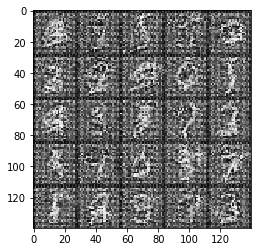

Epoch 1/2... Discriminator Loss: 0.3549... Generator Loss: 1.7373
Epoch 1/2... Discriminator Loss: 0.1886... Generator Loss: 2.5128
Epoch 1/2... Discriminator Loss: 0.1511... Generator Loss: 3.1259
Epoch 1/2... Discriminator Loss: 2.2658... Generator Loss: 0.2092
Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 1.1956
Epoch 1/2... Discriminator Loss: 0.8936... Generator Loss: 0.7949
Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 0.4608
Epoch 1/2... Discriminator Loss: 0.6639... Generator Loss: 1.1389
Epoch 1/2... Discriminator Loss: 0.6115... Generator Loss: 5.6557
Epoch 1/2... Discriminator Loss: 0.5824... Generator Loss: 1.2204


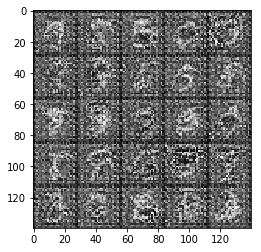

Epoch 1/2... Discriminator Loss: 0.1843... Generator Loss: 2.4710
Epoch 1/2... Discriminator Loss: 0.1132... Generator Loss: 3.9821
Epoch 1/2... Discriminator Loss: 0.4183... Generator Loss: 1.4162
Epoch 2/2... Discriminator Loss: 0.1654... Generator Loss: 3.4325
Epoch 2/2... Discriminator Loss: 0.3457... Generator Loss: 1.8784
Epoch 2/2... Discriminator Loss: 0.6325... Generator Loss: 1.4439
Epoch 2/2... Discriminator Loss: 0.6687... Generator Loss: 0.9257
Epoch 2/2... Discriminator Loss: 3.2450... Generator Loss: 4.0891
Epoch 2/2... Discriminator Loss: 1.3300... Generator Loss: 0.6279
Epoch 2/2... Discriminator Loss: 1.2780... Generator Loss: 0.4114


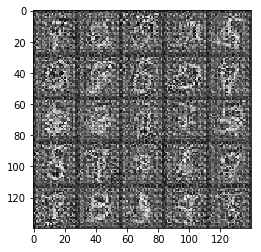

Epoch 2/2... Discriminator Loss: 0.8353... Generator Loss: 2.2185
Epoch 2/2... Discriminator Loss: 1.0538... Generator Loss: 2.2487
Epoch 2/2... Discriminator Loss: 0.9378... Generator Loss: 0.9260
Epoch 2/2... Discriminator Loss: 0.6812... Generator Loss: 0.9579
Epoch 2/2... Discriminator Loss: 0.4554... Generator Loss: 1.8022
Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 2.2488
Epoch 2/2... Discriminator Loss: 0.8076... Generator Loss: 0.9986
Epoch 2/2... Discriminator Loss: 0.6157... Generator Loss: 1.1707
Epoch 2/2... Discriminator Loss: 0.5376... Generator Loss: 1.2504
Epoch 2/2... Discriminator Loss: 0.5506... Generator Loss: 1.2744


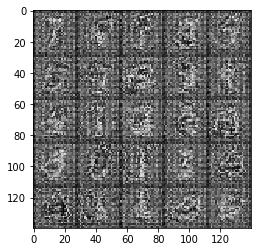

Epoch 2/2... Discriminator Loss: 0.2934... Generator Loss: 2.8618
Epoch 2/2... Discriminator Loss: 0.3522... Generator Loss: 3.7566
Epoch 2/2... Discriminator Loss: 0.1287... Generator Loss: 3.5268
Epoch 2/2... Discriminator Loss: 0.2051... Generator Loss: 5.6815
Epoch 2/2... Discriminator Loss: 0.1588... Generator Loss: 2.6953
Epoch 2/2... Discriminator Loss: 0.2580... Generator Loss: 2.6282
Epoch 2/2... Discriminator Loss: 0.3886... Generator Loss: 2.3998
Epoch 2/2... Discriminator Loss: 0.1208... Generator Loss: 4.2956
Epoch 2/2... Discriminator Loss: 0.1225... Generator Loss: 2.7861
Epoch 2/2... Discriminator Loss: 0.2161... Generator Loss: 3.0456


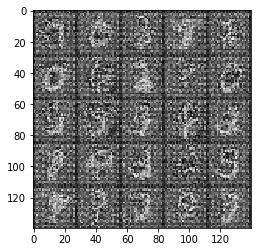

Epoch 2/2... Discriminator Loss: 0.2069... Generator Loss: 5.4315
Epoch 2/2... Discriminator Loss: 0.3477... Generator Loss: 1.6947
Epoch 2/2... Discriminator Loss: 3.0112... Generator Loss: 6.0314
Epoch 2/2... Discriminator Loss: 0.9353... Generator Loss: 2.5142
Epoch 2/2... Discriminator Loss: 0.9392... Generator Loss: 0.9264
Epoch 2/2... Discriminator Loss: 0.7968... Generator Loss: 0.9781
Epoch 2/2... Discriminator Loss: 0.3891... Generator Loss: 2.8620
Epoch 2/2... Discriminator Loss: 0.3778... Generator Loss: 1.7665
Epoch 2/2... Discriminator Loss: 0.2935... Generator Loss: 2.3668
Epoch 2/2... Discriminator Loss: 0.2664... Generator Loss: 2.2174


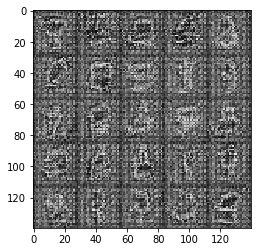

Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 1.3523
Epoch 2/2... Discriminator Loss: 1.3267... Generator Loss: 0.5403
Epoch 2/2... Discriminator Loss: 1.2443... Generator Loss: 0.4115
Epoch 2/2... Discriminator Loss: 0.9419... Generator Loss: 0.7638
Epoch 2/2... Discriminator Loss: 0.7385... Generator Loss: 1.6237
Epoch 2/2... Discriminator Loss: 0.7351... Generator Loss: 1.9119
Epoch 2/2... Discriminator Loss: 0.8280... Generator Loss: 1.8429
Epoch 2/2... Discriminator Loss: 0.7355... Generator Loss: 2.4119
Epoch 2/2... Discriminator Loss: 0.6448... Generator Loss: 1.3791
Epoch 2/2... Discriminator Loss: 0.3366... Generator Loss: 2.4415


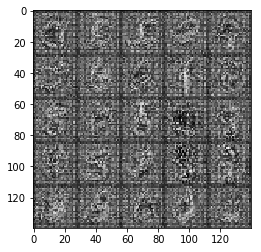

Epoch 2/2... Discriminator Loss: 0.4945... Generator Loss: 3.9479
Epoch 2/2... Discriminator Loss: 0.3220... Generator Loss: 1.9790
Epoch 2/2... Discriminator Loss: 0.1343... Generator Loss: 3.1105
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 0.6660
Epoch 2/2... Discriminator Loss: 0.0954... Generator Loss: 5.9761
Epoch 2/2... Discriminator Loss: 0.1532... Generator Loss: 2.8930
Epoch 2/2... Discriminator Loss: 0.0776... Generator Loss: 4.9390
Epoch 2/2... Discriminator Loss: 0.1234... Generator Loss: 4.3769
Epoch 2/2... Discriminator Loss: 0.4041... Generator Loss: 1.8313
Epoch 2/2... Discriminator Loss: 2.1944... Generator Loss: 4.4022


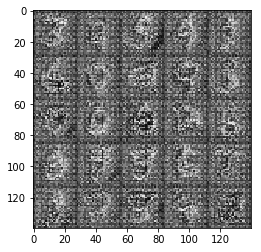

Epoch 2/2... Discriminator Loss: 2.0205... Generator Loss: 0.1868
Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 0.6391
Epoch 2/2... Discriminator Loss: 0.6019... Generator Loss: 1.5252
Epoch 2/2... Discriminator Loss: 0.4611... Generator Loss: 1.5637
Epoch 2/2... Discriminator Loss: 0.2367... Generator Loss: 3.0170
Epoch 2/2... Discriminator Loss: 0.3434... Generator Loss: 1.7703
Epoch 2/2... Discriminator Loss: 0.3374... Generator Loss: 1.9285
Epoch 2/2... Discriminator Loss: 0.6288... Generator Loss: 1.0236
Epoch 2/2... Discriminator Loss: 0.0655... Generator Loss: 4.9222
Epoch 2/2... Discriminator Loss: 0.5573... Generator Loss: 1.1801


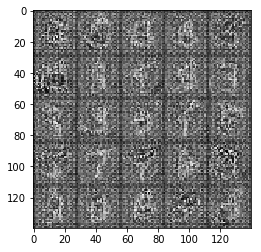

Epoch 2/2... Discriminator Loss: 0.0920... Generator Loss: 7.4587
Epoch 2/2... Discriminator Loss: 0.2802... Generator Loss: 1.8960
Epoch 2/2... Discriminator Loss: 0.1841... Generator Loss: 2.3714
Epoch 2/2... Discriminator Loss: 0.0400... Generator Loss: 6.0655
Epoch 2/2... Discriminator Loss: 0.1919... Generator Loss: 2.4730
Epoch 2/2... Discriminator Loss: 0.0871... Generator Loss: 6.6378
Epoch 2/2... Discriminator Loss: 0.1640... Generator Loss: 2.5504
Epoch 2/2... Discriminator Loss: 0.0538... Generator Loss: 5.8659
Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 1.0969
Epoch 2/2... Discriminator Loss: 0.0777... Generator Loss: 3.7764


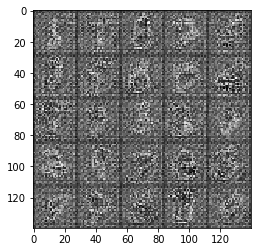

Epoch 2/2... Discriminator Loss: 0.0608... Generator Loss: 4.9826
Epoch 2/2... Discriminator Loss: 0.7892... Generator Loss: 1.0704
Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 0.7246
Epoch 2/2... Discriminator Loss: 1.0313... Generator Loss: 0.6572
Epoch 2/2... Discriminator Loss: 0.8174... Generator Loss: 0.8201
Epoch 2/2... Discriminator Loss: 0.6911... Generator Loss: 1.2657
Epoch 2/2... Discriminator Loss: 1.2662... Generator Loss: 0.4602
Epoch 2/2... Discriminator Loss: 0.4383... Generator Loss: 2.3068
Epoch 2/2... Discriminator Loss: 0.6499... Generator Loss: 1.3266
Epoch 2/2... Discriminator Loss: 0.4776... Generator Loss: 1.3388


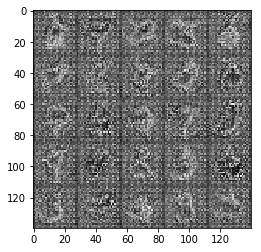

Epoch 2/2... Discriminator Loss: 0.4247... Generator Loss: 1.7288
Epoch 2/2... Discriminator Loss: 0.2743... Generator Loss: 2.1238
Epoch 2/2... Discriminator Loss: 0.2493... Generator Loss: 2.8600
Epoch 2/2... Discriminator Loss: 0.6139... Generator Loss: 1.2275
Epoch 2/2... Discriminator Loss: 0.6746... Generator Loss: 2.4147
Epoch 2/2... Discriminator Loss: 0.6901... Generator Loss: 1.1788
Epoch 2/2... Discriminator Loss: 0.7905... Generator Loss: 0.8009


In [56]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.4850
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.5600


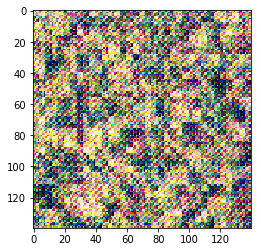

Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.7525


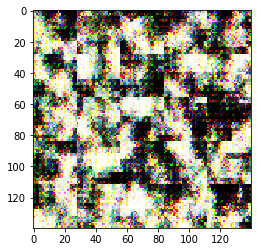

Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7210


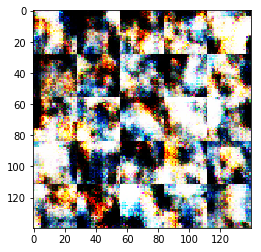

Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6526


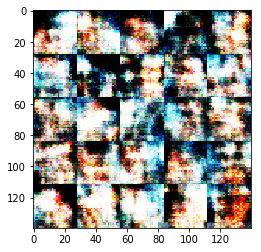

Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.6608


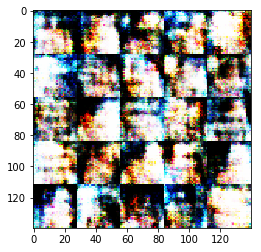

Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.6243


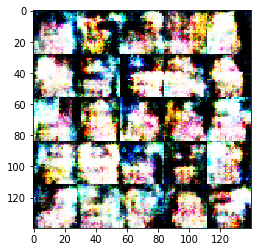

Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.6365


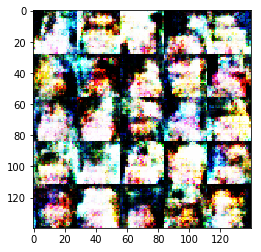

Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6324


KeyboardInterrupt: 

In [48]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.